## Config

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import random
import itertools
from itertools import chain

from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

VERSION:  3.7.0


In [2]:
os_path = '/Users/milk/Desktop/git/'
forms_dir = os_path + 'InformedConsentForms/data/all_forms'

In [3]:
nlp = spacy.load('en')
nlp_larg = spacy.load('en_core_web_lg')

## Semantic Clues

In [4]:
##  taken from: 
# “I found great synonyms for ‘permission’ on the new Thesaurus.com!,”
# www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
## [Accessed: 19-Feb-2019].

permission_bases = ["permission", 
                    "authorization", 
                    "authorize",
                    "consent",
                    "assent",
                    "permit",
                    "approve",
                    "grant",
                    "allow",
                    "certify"]

## add synonyms

In [5]:
def addWordNetSynsets(word_list):
    " add synsets to new list "
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        synonyms = wordnet.synsets(word, 'v')
        synonyms = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
        
        [updated_list.append(x) for x in synonyms if x not in updated_list]
        
    return updated_list
        
permission_extended = addWordNetSynsets(permission_bases)
print('num elements:', len(permission_extended))
[print(x) for x in permission_extended]

num elements: 51
permission
authorization
authorize
authorise
pass
empower
clear
consent
go_for
accept
assent
accede
acquiesce
permit
let
tolerate
countenance
allow
approve
sanction
O.K.
okay
grant
accord
award
deed_over
give
concede
allot
yield
cede
allow
reserve
give_up
take_into_account
provide
admit
appropriate
leave
allow_for
set_aside
earmark
certify
manifest
attest
licence
indorse
license
endorse
evidence
demonstrate


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## build consent form data structure
get dict and dataframe from each consent form on file

#### todo: get metadata

In [6]:
def getData(directory):
    """ returns a dict with cleaned filenames, full paths,
    and text data in multiple formats from a dictionary
    of .txt files"""
    
    fileDictionary = {}
    fileID = 0
    
    # iterate through directory
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            fileID += 1
            filepath = subdir + os.sep + file
            
            if filepath.endswith('.txt'):
                wordList = [] # this will include duplicates and stop words
                cleanedFileName = ''.join(e for e in file if e.isalnum())[:-3] 
                
                # perform string operations on each file
                with open(filepath, 'r') as myfile:
                    data = myfile.read().replace('\n', ' ')       
                
                fileDictionary[fileID] = {}
                fileDictionary[fileID]['name'] = cleanedFileName
                fileDictionary[fileID]['path'] = filepath
                fileDictionary[fileID]['rawText'] = data
    
    return fileDictionary

# run the function and store to variable 
consent_dictionary = getData(forms_dir)

In [7]:
#test print statement
[print(k,v, '\n') for k,v in consent_dictionary[1].items()]

name TAMUHRPPInformedconsent 

path /Users/milk/Desktop/git/InformedConsentForms/data/all_forms/TAMU - HRPP Informed consent.txt 

rawText ﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APPROVAL  This document is a template for editing to delete highlighted and parenthetical sections.  Project Title:   You are invited to take part in a research study being conducted by Investigator Name, a researcher from Texas A&M University and funded by [name sponsor/funding source]. The information in this form is provided to help you decide whether or not to take part. If you decide to take part in the study, you will be asked to sign this consent form. If you decide you do not want to participate, there will be no penalty to you, and you will not lose any benefits you normally would have.  You may choose to withdraw from the study at any time without penalty.  NOTE:  If you are employed then it is your responsibility to work with your employer regarding work leave for participation in this study if d

[None, None, None]

In [8]:
def toDataFrame(fileDictionary):
    """ return pandas dataframe
    Note: expects input in nested dict format (output from getData)"""
    new_rows = []

    for key, value in fileDictionary.items():
        new_rows.append(value)
         
    df = pd.DataFrame(new_rows)
    return df

df = toDataFrame(consent_dictionary)

df.head(3)

,name,path,rawText
0,TAMUHRPPInformedconsent,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...
1,PotomacPrimaryCarefluconsentform,/Users/milk/Desktop/git/InformedConsentForms/d...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...
2,OSUScheduledDeliveryConsent,/Users/milk/Desktop/git/InformedConsentForms/d...,SCHEDULED DELIVERY: Today’s Date: Da...


## Random sampling to speed up development
This will be removed when we want to process the whole corpus

In [9]:
# comment out to run on whole corpus
n_samples = 50
df = df.sample(n=n_samples)

## add spacy object to dataframe

#### WARNING: this takes a long time,

In [10]:
def getDocObjects(row, field):
    " return spacy doc object"
#     # small nlp library
#     doc = nlp(str(row[field]).lower())

    # large library
    doc = nlp_larg(str(row[field]).lower())
    return doc

df['docOB'] = df.apply(lambda row:getDocObjects(row, 'rawText'),axis=1)

In [11]:
df['docOB'].head()

593    (﻿version, :, 08/2013, case, western, reserve,...
694    (﻿,  , protocol, title, :, principal, investig...
366    (michaelzidile, ,, d.d.s, ., practice, limited...
331    (release, of, liability, _, _, _, _, _, _, _, ...
153    (﻿,  , emory, university, and, children, ’s, h...
Name: docOB, dtype: object

## extract sentences

In [12]:
def getSentenceList(row, field):
    " return list of sents from doc object"
    sent_list = []
    
    # must operate on a spaCy doc object 
    for sent in row[field].sents:
#         print(dir(sent))
        sent_list.append(sent)
    
    return sent_list

df['sentList'] = df.apply(lambda row:getSentenceList(row, 'docOB'),axis=1)

In [13]:
def getWordListasString(row):
    """ return a list of words, including duplicates.
    NOTE: light cleaning on ingestion """
    wordList = [] 
    
    for word in row['rawText'].split():
        word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
        if not word == "":
            wordList.append(word)
            
    return " ".join(wordList)
        
df['cleanedText'] = df.apply(lambda row: getWordListasString(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,cleanedText
593,ExampleChildAssentFormforChildrenuptoAge8,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿Version: 08/2013 CASE WESTERN RESERVE UNIVERS...,"(﻿version, :, 08/2013, case, western, reserve,...","[(﻿version, :, 08/2013, case, western, reserve...",version case western reserve university inform...
694,CRCTemplateDec2013,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ Protocol Title: Principal Investigator: Des...,"(﻿, , protocol, title, :, principal, investig...","[(﻿, ), (protocol, title, :, principal, inves...",protocol title principal investigator descript...


## preliminary permisison sentence extraction
look for sentences that have a word from the 'clues' list

# NOTE: DO WE WANT SENTENCE PAIRS? THREE SENTENCES?

If sentence contains contains multiple clues, it should only be added once.

In [14]:
def getPossiblePermissions(row, permissions_list):
    """ return list of sentences containing the 
    permissions words """
    
    sent_list = []
    
    for sent in row['sentList']:
        [sent_list.append(sent) for clue in\
             permission_extended if sent.text.__contains__(clue)]
                
    return sent_list

# here we only convert the first 10 rows to save time
df['permissionsStatements'] = df.apply(lambda row:getPossiblePermissions(row, permission_extended),axis=1)

In [15]:
for sent in df['permissionsStatements'][:10]:
    [print('sent:', x.text, '\n') for x in sent[:2]]

sent: ﻿version: 08/2013 case western reserve university informed assent document to be used with minors up to age 17 insert title of study   

sent: ﻿version: 08/2013 case western reserve university informed assent document to be used with minors up to age 17 insert title of study   

sent: protocol title: principal investigator: description of subject population: version date:  instructions:  this template is only part of the informed consent process.   

sent: many sections of this document include brief instructions and wording suggestions in bold font to provide investigators with a general overview of information required in the section.   

sent: practice limited to periodontics & implant dentistry  surgical placement of dental implants information and consent form diagnosis. 

sent: healing will be allowed to proceed for a period of three to nine months. 

sent: i have been advised to have the following radiographs (x-rays) taken as part of a complete and thorough exam, in order

In [16]:
def getEstimatedPermissionDesnity(row):
    """ return proportion of sentence total that may
    be statements indicating perissions. Expect much noise. """
     
    return len(row['permissionsStatements'])/len(row['sentList'])
    
df['permissionDensity'] = df.apply(lambda row: getEstimatedPermissionDesnity(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,cleanedText,permissionsStatements,permissionDensity
593,ExampleChildAssentFormforChildrenuptoAge8,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿Version: 08/2013 CASE WESTERN RESERVE UNIVERS...,"(﻿version, :, 08/2013, case, western, reserve,...","[(﻿version, :, 08/2013, case, western, reserve...",version case western reserve university inform...,"[(﻿version, :, 08/2013, case, western, reserve...",0.166667
694,CRCTemplateDec2013,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ Protocol Title: Principal Investigator: Des...,"(﻿, , protocol, title, :, principal, investig...","[(﻿, ), (protocol, title, :, principal, inves...",protocol title principal investigator descript...,"[(protocol, title, :, principal, investigator,...",0.122407


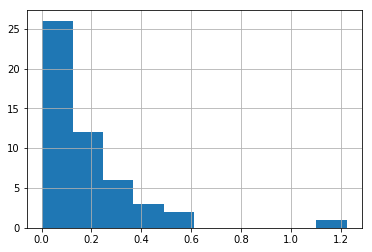

In [17]:
%matplotlib inline
df['permissionDensity'].hist()

## Important
this represents an important break away from the primary dataframe. here i start to work with list structures to create a list of possible permissions that is no longer tied to filenames

In [18]:
all_sents = []

for sentlist in df['sentList'].to_list():
    [all_sents.append(x) for x in sentlist]
    
all_permissions = []

for permlist in df['permissionsStatements'].to_list():
    [all_permissions.append(x) for x in permlist]

In [19]:
print('total rough draft permissions: ', len(all_permissions))
print('unique rough draft permissions: ', len(list(set(all_permissions))))

print('total rough draft sentences: ', len(all_sents))
print('unique rough draft sentences: ', len(list(set(all_sents))))

total rough draft permissions:  1583
unique rough draft permissions:  1227
total rough draft sentences:  20024
unique rough draft sentences:  20024


In [20]:
# remove duplucates
all_permissions = list(set(all_permissions))

## pair-wise similarity between our permission 'guesses' and remaining sentences
this is an important step so that we don't restrict ourselves to permission statements that contain the words we dreampt up

# WARNING: WILL NOT SCALE, need to fix


In [21]:
new_rows = []

for sent in all_sents:
    for perm in all_permissions:
        row = {
            'permission':perm,
            'sentence':sent,
            'similarity':sent.similarity(perm)
        }
        new_rows.append(row)

In [22]:
sf = pd.DataFrame(new_rows)
sf.head()

,permission,sentence,similarity
0,"(vaccine, to, be, given, :, el, human, papillo...","(﻿version, :, 08/2013, case, western, reserve,...",0.767336
1,"(as, one, of, your, health, care, providers, i...","(﻿version, :, 08/2013, case, western, reserve,...",0.838693
2,"(hipaa, only, applies, to, health, care, provi...","(﻿version, :, 08/2013, case, western, reserve,...",0.669897
3,"(signature, of, witness, to, consent, process,...","(﻿version, :, 08/2013, case, western, reserve,...",0.921779
4,"(if, you, do, not, authorize, the, use, and, d...","(﻿version, :, 08/2013, case, western, reserve,...",0.908639


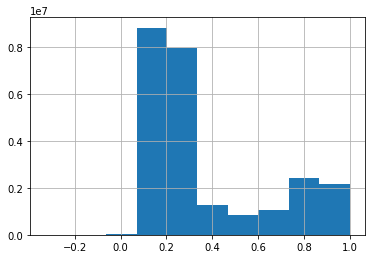

In [23]:
sf['similarity'].hist()

In [24]:
# reduce dataframe, aggregate by mean sim score (weak sents will balance out)
sf = sf.drop(columns=['permission'])
sf = sf.groupby(['sentence'], as_index=False).mean()

sf.head()

,sentence,similarity
0,"(﻿version, :, 08/2013, case, western, reserve,...",0.854312
1,"(﻿, ...",0.851192
2,"(consent, for, mri, patient, name, :)",0.689181
3,"(michaelzidile, ,, d.d.s, .)",0.554262
4,"(informational, use, only, consent, for, denta...",0.837474


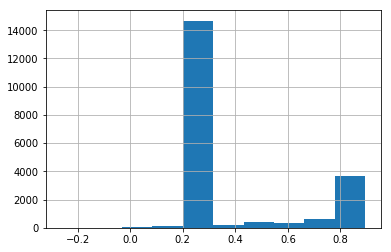

In [25]:
sf['similarity'].hist()

In [26]:
high_sim = sf[sf.similarity > .7]
candidates = high_sim['sentence'].to_list()

In [27]:
print('total rough draft candidates: ', len(candidates))
print('unique rough draft candidates: ', len(list(set(candidates))))

total rough draft candidates:  4130
unique rough draft candidates:  4130


In [28]:
[print('sent: ', x, '\n') for x in candidates[:5]]

sent:  ﻿version: 08/2013 case western reserve university informed assent document to be used with minors up to age 17 insert title of study   

sent:  ﻿                                                 consent form template		                          template v. 03/12/2014  a consent form is one part of an on-going dialogue between researchers and participants.   

sent:  informational use only consent for dental/oral surgical treatment in patients who have received bisphosphonate drugs patient name :  patient chart # :  today’s date : please initial each paragraph after reading. 

sent:  ﻿ this assent document applies to:  _ 

sent:  ﻿*please revise or remove language in red  informed consent forms should be written in simple language that is understandable at an 8th grade reading level  tufts medical center tufts university department name  informed consent to participate in research   title of study  principal investigator: co-investigators: study team telephone number:  this consent

[None, None, None, None, None]

In [29]:
rough_draft_permissions = all_permissions + candidates

In [30]:
print('total rough draft candidates: ', len(rough_draft_permissions))
print('unique rough draft candidates: ', len(list(set(rough_draft_permissions))))

total rough draft candidates:  5357
unique rough draft candidates:  4202


In [31]:
rough_draft_permissions = list(set(rough_draft_permissions))

## print statements to file

In [32]:
# import csv
# import datetime
# today = str(datetime.date.today())

# file_path = 'statements-'+today+'.csv'
# print(file_path)

# with open(file_path, 'a') as outcsv:   
#     #configure writer to write standard csv file
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['raw_text', 'clean_text'])
#     for perm in rough_draft_permissions:
#         #Write item to outcsv
#         raw_text = perm.text
#         clean_text = re.sub('\s+', ' ', re.sub('\W+',' ',\
#                                re.sub('[^A-Za-z0-9]+',' ', \
#                                       re.sub(r'\d+', " ", raw_text)))).strip()
#         writer.writerow([raw_text, clean_text])

# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.

## matrix representations

a few different matrix representations of the permissions sentence

In [33]:
def cleanPermissions(rough_draft_permissions):
    "string cleaning on permissions for td-idf ingestion"
    corpus = []
    
    
    for permission in rough_draft_permissions:
        cleanSentence = []
        for word in permission.text.split():
            word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
            if not word == "":
                cleanSentence.append(word)
        corpus.append(" ".join(cleanSentence))
    return corpus
            
corpus = cleanPermissions(rough_draft_permissions)

[print(x, '\n') for x in corpus[:10]]

for clinical trials taking part in a research study is not the same as getting regular medical care 

insert whichever type of recording is applicable to your study 

as one of your health care providers it is our responsibility to keep your information safe and secure 

signature of witness to consent process date and time printed name of person witnessing consent process icahn school of medicine at mount sinai and the mount sinai hospital consent form to volunteer in a research study and authorization for use and disclosure of medical information page of study 

note the preceding sentence can be eliminated if you have obtained a certificate of confidentiality for the study data 

if you do not authorize the use and disclosure of your phi for the study then you may not participate in the research study or receive research related treatment 

i have been given the opportunity 

consent please print your name and sign below if you agree to be in this study 

why are you doing this rese

[None, None, None, None, None, None, None, None, None, None]

## NOTE: 
`minTermFrequencyThreshold = 0` will result in all possible n_grams and will not scale as input size or ngramSize increases. However, it is the most robust representation of the sentence, and is worth exploring for the time being...

In [34]:
ngramSize = 5
maxTermFrequencyThreshold = .8
minTermFrequencyThreshold = .001

def getTDIDFMatrix(corpus, ngram_range, max_df, min_df):
    """ return td-idf matrix and terms """
    
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                       ngram_range=(1,ngram_range),
                                       max_df=max_df,min_df=min_df)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names()
    
    return tfidf_matrix, terms

# save to a variable 
tdidf_matrix, tdidf_terms = getTDIDFMatrix(corpus, 
                                           ngramSize, 
                                           maxTermFrequencyThreshold,
                                           minTermFrequencyThreshold)

# # print tests
# print('\nfirst few terms:')
# [print(" ", x) for x in tdidf_terms[:10]]

print('\nNumber of terms:', len(tdidf_terms))


Number of terms: 7358


In [35]:
sdf = pd.SparseDataFrame(tdidf_matrix, columns=tdidf_terms)

# here we add the sentences back in
sdf['sent'] = corpus

sdf.head()

,ability,ability to,able,able to,about,about how,about it,about minutes,about my,about the,...,your study,your study doctor,your study information,your time,your tissue,your treatment,your treatment if,your treatment if you,yourself,yourself or
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.257045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
permission_vectors = []

for perm in rough_draft_permissions:
#     print(perm.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])) # same features, different rows
#     print(perm.vector) # same shape
#     print(perm.vector_norm) # single value
#     print(perm.get_lca_matrix()) # differnt shapes
    permission_vectors.append(perm.vector)